# CoCo: Learning how to use Fatiando a Terra tools

In this notebook we will learn how we can use the Fatiando a Terra tools to
process gravity data (or any spatial data).

Processing gravity data might seem easy, although there are a lot of details
that we must to take into account.
Nevertheless, the idea of this notebook is not to become experts on gravity
modelling, but to use it as an excuse for learning more Python and how should
we approach learning a new library.

A very nice place to start learning a new tool is its website and its
documentation pages.

The Fatiando a Terra project has its own website: https://www.fatiando.org

The project is composed by different open-source Python libraries, each one
with a specific goal and set of problems that they tackle.
Each one of these libraries has its own documentation pages:
- Pooch: https://www.fatiando.org/pooch
- Boule: https://www.fatiando.org/boule
- Verde: https://www.fatiando.org/verde
- Harmonica: https://www.fatiando.org/harmonica
    
## Goals

1. Fetch and cache the data using [Pooch](https://github.com/fatiando/pooch)
1. Calculate the gravity disturbance using [Boule](https://github.com/fatiando/boule)
1. Interpolate data and apply map projections to grids using [Verde](https://github.com/fatiando/verde)
1. Perform topographic correction and equivalent-source interpolation using [Harmonica](https://github.com/fatiando/harmonica)
    
---

En este notebook vamos a aprender cómo podemos utilizar las herramientas de
Fatiando a Terra para procesar datos de gravedad (o cualquier tipo de dato
espacial).

El procesamiento de datos gravimétricos puede parecer sencillo, sin embargo hay
muchos detalles que se deben tener en cuenta.
Sin embargo, la idea de este notebook no es convertirnos en expertxs en el
modelado gravimétrico, sino utilizarlo como excusa para aprender más sobre
Python y cómo debemos proceder a la hora de aprender una nueva librería.

Un muy buen lugar para comenzar a aprender una nueva librería es su sitio web
y sus páginas de documentación.

El proyecto Fatiando a Terra posee su propia página web:
https://www.fatiando.org

El proyecto está compuesto por diferentes librerías open-source escritas en
Python, cada una con objetivos específicos y problemas que permiten resolver.
Cada una de estas librerías posee sus propias páginas de documentación:
- Pooch: https://www.fatiando.org/pooch
- Boule: https://www.fatiando.org/boule
- Verde: https://www.fatiando.org/verde
- Harmonica: https://www.fatiando.org/harmonica
    
    
## Objetivos

- Importar librerías nuevas
- Leer documentación (online y docstrings)
- Descargar datos con Pooch
- Manipular datos espaciales con Verde
- Calcular gravedad normal con Boule
- Procesar datos gravimétricos con Harmonica


## Study area | Área de estudio

The **Bushveld Igneous Complex** is located in South Africa and is the largest known layered igneous intrusion. It has been tilted and eroded forming the outcrops around what appears to be the edge of a great geological basin: the Transvaal Basin. It is approximately 2 billion years old and is divided into four different limbs: the northern, southern, eastern, and western limbs. The Bushveld Complex comprises the Rustenburg Layered suite, the Lebowa Granites and the Rooiberg Felsics, that are overlain by the Karoo sediments. See [Webb et al. (2004)](https://doi.org/10.2113/107.1-2.207) for an overview and previous interpretations of the Bushveld in depth.

<figure>
<img src="images/bushveld_igneous_complex_geology.jpg" alt="Geologic map of the Bushveld Complex">
<figcaption><em>
    Geology and mineral exploration sites of the Bushveld Igneous Complex 
    (<a href="https://en.wikipedia.org/wiki/File:Bushveld_Igneous_Complex.png">public domain</a>).
</em></figcaption>
</figure>

## Import packages | Importar paquetes

Import Numpy, Pandas and Matplotlib for managing and plotting our data.

Importemos Numpy, Pandas y Matplotlib para gestionar nuestros datos y graficarlos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Lets import Xarray, a library similar to Pandas, but it allows us to work with multidimensional data besides tabular data.

Importemos Xarray, una librería similar a Pandas, pero que nos permite trabajar con datos multidimensionales en vez de datos tabulados.

In [2]:
import xarray as xr

Lets import **pyproj**: it will help us to convert geographic coordinates into Cartesian coordinates through map projections.

Importemos **pyproj** para poder convertir coordeanadas geográficas en coordenadas Cartesianas mediante proyecciones.

In [3]:
import pyproj

Finally, lets import some Fatiando libraries.

Finalmente, importemos algunas librerías de Fatiando.

In [4]:
import pooch
import verde as vd
import boule as bl
import harmonica as hm

## Fetch data | Descarguemos datos

En este notebook vamos a utilizar tres tipos de datos diferentes:

- **datos gravimétricos**: vamos a utilizar un conjunto de  datos gravimétricos sobre Sudáfrica.Estos datos consisten en mediciones de la aceleración gravitatoria producida por el planeta Tierra sobre diferentes puntos de observación ubicados sobre la superficie de Sudáfrica. Los datos gravimétricos vienen dados en mGal, una unidad que equivale a 1e5 m/s^2.
- **topografía de Sudáfrica**: el último paso de este notebook consistirá en remover el efecto gravitatorio de la topografía de Sudáfrica de nuestros datos. Para ello necesitamos un DEM (modelo de elevación digital) o una grilla de topografía.

Todos estos datos se encuentran disponibles bajo licencia Creative Commons Attribution en https://doi.org/10.5281/zenodo.5167357.
Veamos cómo podemos utilizar Pooch para descargar estos datos a nuestra computadora para luego poder cargarlos en nuestros notebooks.

Definimos el Digital Object Identified (DOI) del archivo de Zenodo en el cual se encuentran nuestros datos.

In [5]:
doi = "10.5281/zenodo.5167357"

Utilicemos la función `pooch.retrieve` para descargar los archivos de datos `southern-africa-gravity.csv.xz` y `earth-topography-10arcmin.nc`. Además, vamos a utilizar la suma de comprobación de estos archivos, de forma tal que Pooch pueda verificar que los archivos que se descarguen no estén corruptos.

In [6]:
gravity = f"doi:{doi}/southern-africa-gravity.csv.xz"
gravity_hash = "md5:1dee324a14e647855366d6eb01a1ef35"

path_gravity = pooch.retrieve(gravity, known_hash=gravity_hash, progressbar=True)
path_gravity

'/home/santi/.cache/pooch/54dd32a533b3783209a50adf11640117-southern-africa-gravity.csv.xz'

In [7]:
topography = f"doi:{doi}/earth-topography-10arcmin.nc"
topography_hash = "md5:c43b61322e03669c4313ba3d9a58028d"

path_topography = pooch.retrieve(
    topography, known_hash=topography_hash, progressbar=True
)
path_topography

'/home/santi/.cache/pooch/cfd6d849435e1ca109cf31d2dae3fe32-earth-topography-10arcmin.nc'

## Load the data | Cargar los datos

Comencemos por los **datos gravimétricos**. Dado que los datos de gravedad que descargamos consiste en un archivo CSV (comprimido en un .xz), vamos a utilizar Pandas para leerlo.

In [8]:
data = pd.read_csv(path_gravity)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


Los datos de **topografía** vienen dados en grillas regulares en archivos netCDF (.nc). Para cargar estos datos vamos a hacer uso de Xarray.

In [9]:
topography = xr.load_dataarray(path_topography)
topography

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data | Grafiquemos los datos

Todos los datos que descargamos se encuentran georeferenciados en coordenadas elipsoidales (latitud, longitud). 
Utilicemos matplotlib para poder visualizar los datos que descargamos.

> **Nota**
> Para graficar datos georeferenciados es recomendable utilizar librerías más adecuadas, como **pyGTM**.
> Con el objetivo de mantener este notebook más simple, utilizaremos matplotlib.

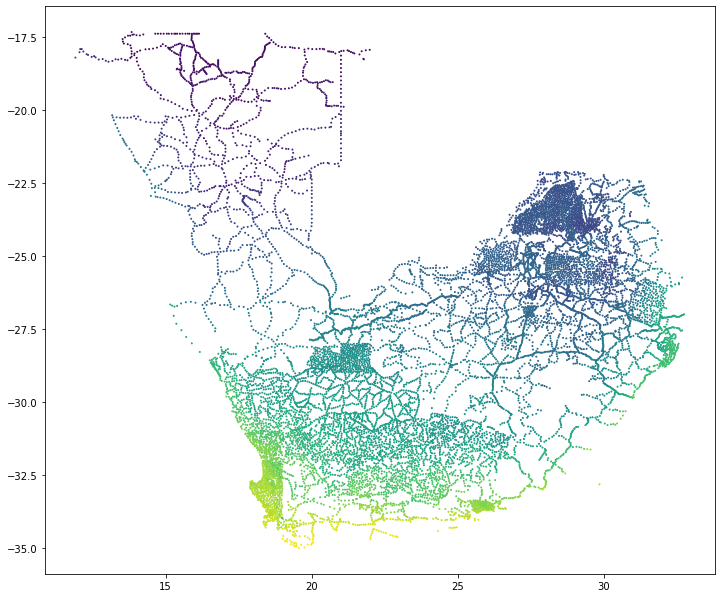

In [10]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(data.longitude, data.latitude, c=data.gravity_mgal, s=1)
plt.gca().set_aspect("equal")
plt.show()

## Crop the data to the Bushveld | Recortemos los datos sobre Bushveld

Como podemos ver, los datos de gravedad pertenecen a toda Sudáfrica, sin embargo nuestra zona de interés es la región de Bushveld. Las grillas de geoide y topografía vamos a recortarlas a regiones un poco más extensas, con el objetivo de evitar efectos de borde en los posteriores procesos.

Definamos la región de Bushveld en grados (oeste, este, sur, norte):

In [11]:
region = (25, 32, -27, -23)

Agrandemos la region para utilizar con las grillas. Para ello haremos uso de la función `vd.pad_region()` de Verde:

In [12]:
region_pad = vd.pad_region(region, pad=5)
region_pad

(20, 37, -32, -18)

Podemos utilizar la función `vd.inside` de Verde para obtener qué datos se encuentran dentro de nuestra región y luego recortarlos con Pandas.

In [13]:
inside_points = vd.inside((data.longitude, data.latitude), region)

data = data[inside_points]
data

,longitude,latitude,height_sea_level_m,gravity_mgal
8648,25.01500,-26.26334,1230.2,978681.38
8649,25.01932,-26.38713,1297.0,978669.02
8650,25.02499,-26.39667,1304.8,978669.28
8651,25.04500,-26.07668,1165.2,978681.08
8652,25.07668,-26.35001,1262.5,978665.19
...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85
12975,31.52499,-23.30000,280.7,978798.55
12976,31.54832,-23.19333,245.7,978803.55
12977,31.57333,-23.84833,226.8,978808.44


Para recortar grillas podemos utilizar directamente el método `sel()` de los `xarray.DataArray`.

In [14]:
topography = topography.sel(
    longitude=slice(region_pad[0], region_pad[1]),
    latitude=slice(region_pad[2], region_pad[3])
)
topography

<xarray.DataArray 'topography' (latitude: 85, longitude: 103)>
array([[ 1013.,  1236.,  1335., ..., -3867., -4446., -4842.],
       [ 1206.,  1270.,  1227., ..., -3790., -4350., -4736.],
       [ 1245.,  1197.,  1104., ..., -3847., -4362., -4703.],
       ...,
       [ 1128.,  1123.,  1113., ...,    -7.,   -32.,   -18.],
       [ 1115.,  1107.,  1098., ...,    17.,   -10.,   -21.],
       [ 1102.,  1094.,  1084., ...,    18.,     9.,   -13.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 20.0 20.17 20.33 20.5 ... 36.67 36.83 37.0
  * latitude   (latitude) float64 -32.0 -31.83 -31.67 ... -18.33 -18.17 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data

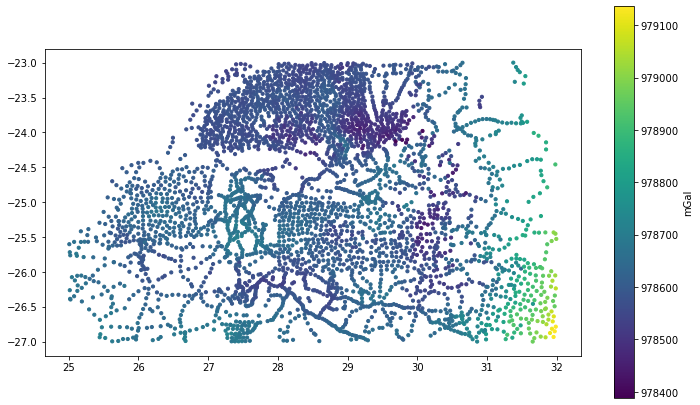

In [15]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(data.longitude, data.latitude, c=data.gravity_mgal, s=10)
plt.colorbar(label="mGal", shrink=0.6)
plt.gca().set_aspect("equal")
plt.show()

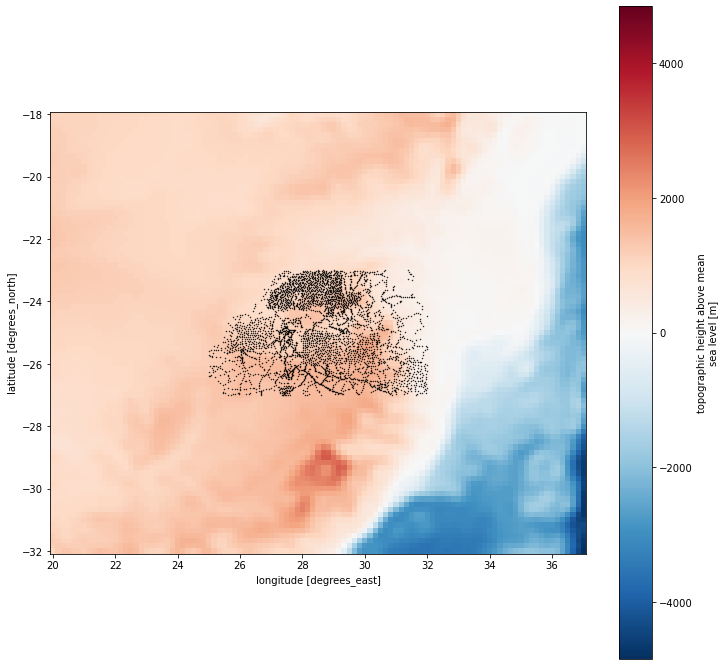

In [16]:
fig = plt.figure(figsize=(12, 12))
topography.plot()
plt.scatter(data.longitude, data.latitude, c="black", s=0.2)
plt.gca().set_aspect("equal")
plt.show()

## Project the data and the grid | Proyectando los datos y la grilla

Dado que nuestra región es los suficientemente pequeña podemos utilizar una proyección para transformar nuestros datos en coordenadas geográficas (longitud, latitud) a coordenadas Cartesianas. Esto simplifica mucho tareas como  la interpolación y las correcciones topográficas, que suelen ser mucho más rápidas en coordenadas Cartesianas que en coordenadas esféricas o geográficas.

Haremos uso de `pyproj` para crear una proyección de tipo Mercator con la latitud de la "escala real" centrada en los datos.

In [17]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

Utilicemos esta `projection` para transformar las coordenadas de nuestros datos de gravedad y luego incluirlas en el mismo `pandas.DataFrame`.

In [18]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06


Projectar grillas es más complicado, ya que involucra realizar algunas interpolaciones a fines de mantener los nodos equiespaciados. Verde posee la función `project_grid` que nos permite calcular todo esto de forma automática. Utilizaremos una interpolación a primeros vecinos dado que es una de las más rápidas y la proyección que elegimos no deforma tanto nuestros datos.

In [19]:
topography_proj = vd.project_grid(topography, projection, method="nearest")
topography_proj

<xarray.DataArray 'topography' (northing: 85, easting: 103)>
array([[ 1.1245e+03,  1.1245e+03,  1.3350e+03, ..., -3.5210e+03,
        -4.4460e+03, -4.8420e+03],
       [ 1.2380e+03,  1.2380e+03,  1.2270e+03, ..., -3.4570e+03,
        -4.3500e+03, -4.7360e+03],
       [ 1.2210e+03,  1.2210e+03,  1.1040e+03, ..., -3.5170e+03,
        -4.3620e+03, -4.7030e+03],
       ...,
       [ 1.1255e+03,  1.1255e+03,  1.1130e+03, ...,  3.5000e+00,
        -3.2000e+01, -1.8000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01],
       [ 1.1045e+03,  1.1045e+03,  1.0910e+03, ...,  1.1750e+01,
        -5.0000e-01, -1.7000e+01]], dtype=float32)
Coordinates:
  * easting   (easting) float64 2.02e+06 2.036e+06 ... 3.72e+06 3.736e+06
  * northing  (northing) float64 -3.393e+06 -3.375e+06 ... -1.855e+06 -1.836e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

## Gravity disturbance | Disturbio de gravedad

El disturbio de gravedad se define como:

$$ \delta g(\lambda, \phi, h) = g(\lambda, \phi, h) - \gamma(\lambda, \phi, h) $$

donde $(\lambda, \phi, h)$ son las coordenadas longitudinales, latitudinales y la altitud del punto de observación, y $\gamma$ es la **gravedad normal** generada por el elipsoide de referencia. Nótese que estas tres cantidades se ubican en el mismo punto de observación.

> **Nota**
> Las altitudes de los datos que descargamos están referidas al nivel del mar, es decir, al geoide. Sin embargo, es recomendable trabajar con altitudes sobre el elipsoide de referencia.
> Con el objetivo de mantener este notebook breve, vamos a saltarnos el paso de transformar las altitudes sobre geoide a altitudes sobre elipsoide.
> Debido a que las diferencias entre ambas son pequeñas, no veremos efectos apreciables al omitir ese paso.
> Para más información sobre cómo se puede realizar este paso referirse a: https://github.com/fatiando/tutorials

Los valores de $g$ sobre los puntos de observación vienen dados en los datos que descargamos, por lo tanto nos resta calcular la gravedad normal en los mismos puntos.
Boule nos permite definir un elipsoide de referencia (usaremos el WGS84) y calcular su efecto gravitatorio en cualquier punto exterior.

Definimos el elipsoide de referencia

In [20]:
ellipsoid = bl.WGS84
ellipsoid

Ellipsoid(name='WGS84', semimajor_axis=6378137, flattening=0.0033528106647474805, geocentric_grav_const=398600441800000.0, angular_velocity=7.292115e-05, long_name='World Geodetic System 1984', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')

Calculamos gravedad normal sobre los puntos de observación

In [21]:
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_sea_level_m)
normal_gravity

8648     978664.712961
8649     978652.988542
8650     978651.268090
8651     978671.426681
8652     978660.964959
             ...      
12974    978785.402819
12975    978754.237140
12976    978758.059200
12977    978807.150366
13557    978733.153054
Length: 3877, dtype: float64

Calculamos el disturbio de gravedad y lo agregamos a nuestro `DataFrame`

In [22]:
gravity_disturbance = data.gravity_mgal - normal_gravity

data = data.assign(gravity_disturbance_mgal=gravity_disturbance)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,gravity_disturbance_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,16.667039
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,16.031458
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,18.011910
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,9.653319
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,4.225041
...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,-8.552819
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,44.312860
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,45.490800
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,1.289634


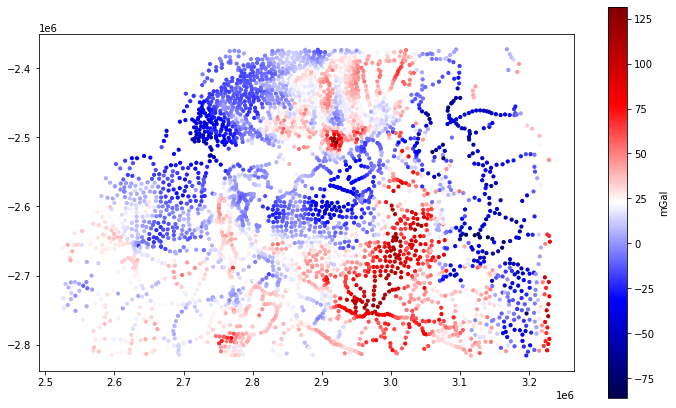

In [23]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(data.easting_m, data.northing_m, c=data.gravity_disturbance_mgal, s=10, cmap="seismic")
plt.colorbar(label="mGal", shrink=0.6)
plt.gca().set_aspect("equal")
plt.show()

## Topographic correction | Corrección topográfica

El disturbio de gravedad contiene toda la información acerca de la aceleración gravitatoria generada por masas anómalas. Uno de los conjuntos que mayor contribuye al disturbio de gravedad es la topografía: aquellos cuerpos que se encuentran por encima del elipsoide de referencia.
El efecto de la topografía nos esconde el efecto de cuerpos enterrados que nos son de mayor de interés (en este caso las rocas ígneas de Bushveld).
Quitemos entonces el efecto de la topografía del disturbio de gravedad.

Harmonica nos permite calcular los efectos gravitatorios de la topografía modelándola con geometrías sencillas como son los prismas rectangulares.

La función `prism_layer` crea un modelo de prismas a partir de una superficie topográfica que ondula alrededor de un nivel de referencia. En nuestro caso el nivel de referencia será el elipsoide (altitud cero) y la superficie será la topografía.

La parte más difícil es asignar la densidad a cada uno de estos prismas:

* $\rho = 2670\ kg/m^3$ para regiones continentales con topografía positiva (por encima del elipsoide)
* $\rho = 1040 - 2670\ kg/m^3$ en los oceanos (1040 es la densidad aproximada del agua del mar)


<figure>
<img src="images/topographic-correction.svg" alt="Sketch of the surfaces and masses involved in topographic correction of gravity disturbances.">
<figcaption><em>
    Sketch of the surfaces and masses involved in topographic correction of gravity disturbances. 
    (CC-BY).
</em></figcaption>
</figure>

> **Nota**
> Existen algunos detalles a considerar al realizar este tipo de correcciones topográficas: el nivel del mar no coincide con la superficie del elipsoide, y por ende hay masas de agua por encima y por debajo del elipsoide.
> Con el objetivo de mantener este notebook breve, hemos obviado estos detalles.
> Para más información al respecto puede referirse a: https://github.com/fatiando/tutorials

In [24]:
density = np.where(topography_proj > 0, 2670, 1040 - 2670)

topography_model = hm.prism_layer(
    coordinates=(topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": density},
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 85, easting: 103)
Coordinates:
  * easting   (easting) float64 2.02e+06 2.036e+06 ... 3.72e+06 3.736e+06
  * northing  (northing) float64 -3.393e+06 -3.375e+06 ... -1.855e+06 -1.836e+06
    top       (northing, easting) float32 1.124e+03 1.124e+03 ... 0.0 0.0
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 -0.5 -17.0
Data variables:
    density   (northing, easting) int64 2670 2670 2670 2670 ... 2670 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

Calculemos ahora el efecto gravitatorio de estos prismas sobre los puntos de observación

In [25]:
coordinates = (data.easting_m, data.northing_m, data.height_sea_level_m)

terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

array([136.77879223, 142.82198061, 142.82177599, ...,  19.40069139,
        17.36464538,  25.68858653])

Guardemos estos valores en nuestro `DataFrame`

In [26]:
data = data.assign(terrain_effect_mgal=terrain_effect)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,16.667039,136.778792
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,16.031458,142.821981
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,18.011910,142.821776
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,9.653319,126.429518
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,4.225041,139.469782
...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,-8.552819,32.979925
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,44.312860,27.684575
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,45.490800,19.400691
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,1.289634,17.364645


Y calculemos el **disturbio de Bouguer** que se define como el disturbio de gravedad menos el efecto de la topografía

In [27]:
gravity_bouguer = data.gravity_disturbance_mgal - data.terrain_effect_mgal

data = data.assign(gravity_bouguer_mgal=gravity_bouguer)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,16.667039,136.778792,-120.111753
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,16.031458,142.821981,-126.790523
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,18.011910,142.821776,-124.809866
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,9.653319,126.429518,-116.776199
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,4.225041,139.469782,-135.244742
...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,-8.552819,32.979925,-41.532744
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,44.312860,27.684575,16.628286
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,45.490800,19.400691,26.090109
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,1.289634,17.364645,-16.075012


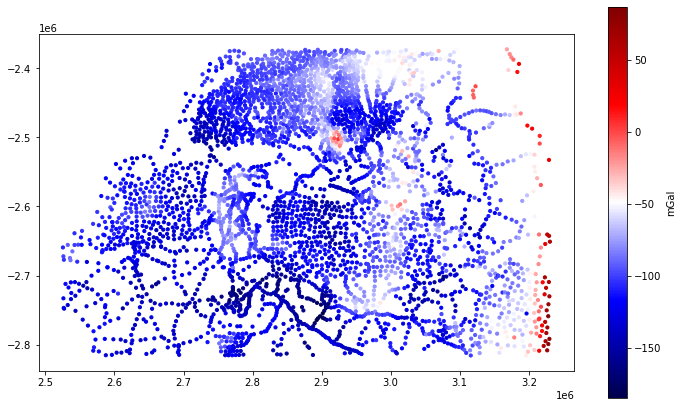

In [28]:
plt.figure(figsize=(12, 12))
plt.scatter(data.easting_m, data.northing_m, c=data.gravity_bouguer_mgal, s=10, cmap="seismic")
plt.colorbar(label="mGal", shrink=0.6)
plt.gca().set_aspect("equal")
plt.show()

## Regional-residual separation

El disturbio de gravedad de Bouguer está dominado principalmente por los effectos de masas muy profundas ubicadas en la interfaz entre la corteza y el manto (discontinuidad de Mohorovicic).
Si queremos observar la señal de los cuerpos ígneos de Bushveld (llamados **residuales**) es necesario que quitemos el efecto de estas masas profundas (llamdas **regionales**).

Para ello vamos a utilizar la técnica de **fuentes equivalentes**:
- definiremos un conjunto de fuentes puntuales profundas
- ajustaremos sus masas de forma tal que generen un campo aproximadamente igual al del disturbio de Bouguer
- calcularemos el efecto **regional** como el efecto que generan estas fuentes en los puntos de observación

<figure>
<img src="images/equivalent-sources.svg" alt="Sketch equivalent sources method to perform interpolation or predict residuals.">
<figcaption><em>
    Sketch equivalent sources method to perform interpolation or predict residuals.
    (CC-BY).
</em></figcaption>
</figure>

Para ello haremos uso de las `EquivalentSources` de Harmonica, que nos permiten llevar a cabo todos estos pasos mediante una interfaz simple de utilizar.

Definimos las fuentes equivalentes ubicadas a 500km de profundidad (el damping es un parámetro de amortiguamiento que permite "suavizar" las masas de las fuentes, un valor alto genera soluciones más suaves).

In [29]:
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3)

Ajustamos las masas de las fuentes con los datos del disturbio de Bouguer

In [30]:
coordinates = (data.easting_m, data.northing_m, data.height_sea_level_m)

deep_sources.fit(coordinates, data.gravity_bouguer_mgal)

/home/santi/.mambaforge/envs/coco-fatiando/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=1000, depth=500000.0)

Calculamos el efecto **regional** como el efecto gravitatorio de estas fuentes profundas

In [31]:
gravity_regional = deep_sources.predict(coordinates)

data = data.assign(gravity_regional_mgal=gravity_regional)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,16.667039,136.778792,-120.111753,-122.064082
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,16.031458,142.821981,-126.790523,-122.073458
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,18.011910,142.821776,-124.809866,-122.097411
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,9.653319,126.429518,-116.776199,-122.155711
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,4.225041,139.469782,-135.244742,-122.333801
...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,-8.552819,32.979925,-41.532744,-58.486904
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,44.312860,27.684575,16.628286,-51.728831
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,45.490800,19.400691,26.090109,-50.054659
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,1.289634,17.364645,-16.075012,-57.094274


Calculamos el efecto **residual** como el disturbio de Bouguer menos el efecto regional

In [32]:
gravity_residual = data.gravity_bouguer_mgal - gravity_regional

data = data.assign(gravity_residual_mgal=gravity_residual)
data

,longitude,latitude,height_sea_level_m,gravity_mgal,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal,gravity_residual_mgal
8648,25.01500,-26.26334,1230.2,978681.38,2.526066e+06,-2.733052e+06,16.667039,136.778792,-120.111753,-122.064082,1.952329
8649,25.01932,-26.38713,1297.0,978669.02,2.526503e+06,-2.746924e+06,16.031458,142.821981,-126.790523,-122.073458,-4.717064
8650,25.02499,-26.39667,1304.8,978669.28,2.527075e+06,-2.747994e+06,18.011910,142.821776,-124.809866,-122.097411,-2.712455
8651,25.04500,-26.07668,1165.2,978681.08,2.529096e+06,-2.712163e+06,9.653319,126.429518,-116.776199,-122.155711,5.379512
8652,25.07668,-26.35001,1262.5,978665.19,2.532295e+06,-2.742763e+06,4.225041,139.469782,-135.244742,-122.333801,-12.910940
...,...,...,...,...,...,...,...,...,...,...,...
12974,31.51500,-23.86333,300.5,978776.85,3.182450e+06,-2.466945e+06,-8.552819,32.979925,-41.532744,-58.486904,16.954161
12975,31.52499,-23.30000,280.7,978798.55,3.183459e+06,-2.405224e+06,44.312860,27.684575,16.628286,-51.728831,68.357117
12976,31.54832,-23.19333,245.7,978803.55,3.185814e+06,-2.393567e+06,45.490800,19.400691,26.090109,-50.054659,76.144768
12977,31.57333,-23.84833,226.8,978808.44,3.188340e+06,-2.465298e+06,1.289634,17.364645,-16.075012,-57.094274,41.019262


Graficamos un mapa del campo resiudal. Este mapa debe tener semejanzas con lo que conocemos acerca de la geología de Bushveld.

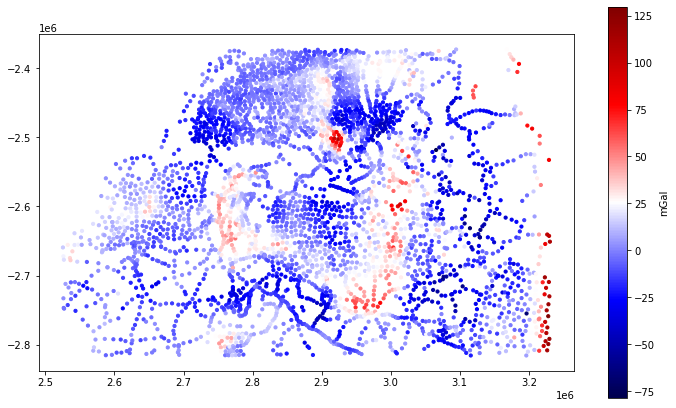

In [33]:
plt.figure(figsize=(12, 12))
plt.scatter(data.easting_m, data.northing_m, c=data.gravity_residual_mgal, s=10, cmap="seismic")
plt.colorbar(label="mGal", shrink=0.6)
plt.gca().set_aspect("equal")
plt.show()

## Grid the residuals | Grillando los campos residuales

Una forma de mejorar la visualización de nuestros resultados es interpolarlos en una grilla regular a altitud constante.

La mejor forma de hacer esto es mediante **fuentes equivalentes**. Vamos a utilizar la misma técnica que en el paso anterior, pero ahora las fuentes no estarán ubicadas a grandes profundidades, sino más someras.
Una vez que ajustemos los coeficientes de las fuentes, vamos a predecir sus efectos gravitatorios en una grilla regular a altitud constante.

Definimos las fuentes equivalentes ubicadas a 10km de profundidad y con un damping de 10 (no queremos soluciones muy suaves) y las ajustamos con los datos

In [34]:
eqs = hm.EquivalentSources(damping=10, depth=10e3)

coordinates = (data.easting_m, data.northing_m, data.height_sea_level_m)
eqs.fit(coordinates, data.gravity_residual_mgal)

/home/santi/.mambaforge/envs/coco-fatiando/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=10, depth=10000.0)

Calculamos el efecto de las fuentes sobre una grilla regular a 2200 metros de altitud, con una resolución de 2 minutos de arco.

In [35]:
residual_grid = eqs.grid(
    upward=2200,  # height in meters
    spacing=3000,  # spacing in meters
    data_names=["gravity_residual"],
)
residual_grid

<xarray.Dataset>
Dimensions:           (northing: 149, easting: 236)
Coordinates:
  * easting           (easting) float64 2.525e+06 2.528e+06 ... 3.231e+06
  * northing          (northing) float64 -2.816e+06 -2.813e+06 ... -2.372e+06
    upward            (northing, easting) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual  (northing, easting) float64 0.7945 0.897 ... 20.33 19.64
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

Graficamos la grilla

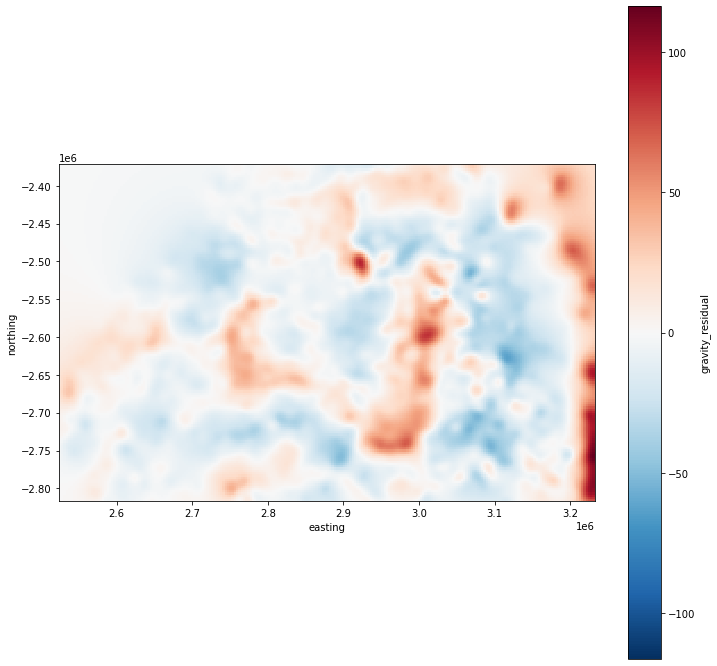

In [36]:
plt.figure(figsize=(12, 12))
residual_grid.gravity_residual.plot()
plt.gca().set_aspect("equal")
plt.show()

---

## License

All Python source code is made available under the BSD 3-clause license. You
can freely use and modify the code, without warranty, so long as you provide
attribution to the authors.

Unless otherwise specified, all figures and Jupyter notebooks are available
under the Creative Commons Attribution 4.0 License (CC-BY).

The full text of these licenses is provided in the [`LICENSE.txt`](LICENSE.txt)
file.